### This notebook aims to plot the results

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import json
from dotenv.main import load_dotenv
import os
from datetime import datetime

load_dotenv(override=True)

True

In [ ]:
df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY
Date,,,,,,
2005-10-10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2005-10-11,1.003231,1.006833,1.004578,0.998658,0.998084,0.995925
2005-10-12,0.999670,0.997110,0.996675,0.996056,0.996517,0.991573
2005-10-13,0.981077,0.986449,0.997260,0.993734,0.993465,0.988179
2005-10-14,0.973370,0.987997,0.994278,0.993174,0.993525,0.989778


In [ ]:
def get_benchmark_returns(start_date, end_date):

    filtered_df = df[(df.index >= str(start_date)) & (df.index <= str(end_date))]
    
    daily_returns = filtered_df
    
    egbi_returns = daily_returns["GOV"]
    cumulative_egbi_returns = (1 + egbi_returns).cumprod()
    
    msci_returns = daily_returns["MSCIWORLD"]
    cumulative_msci_returns = (1 + msci_returns).cumprod()
    
    return cumulative_egbi_returns, cumulative_msci_returns, daily_returns


In [5]:
def load_portfolio_weights(json_file):
    """
    Load portfolio weights, expected returns, and periods from the JSON file.
    """
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    all_runs = []
    for entry in data:
        pareto_front = []
        for solution in entry.get("solutions", []):
            # Ensure solution is a dictionary
            if isinstance(solution, dict):
                pareto_front.append({
                    "weights": solution.get("weights", []),
                    "expected_return": solution.get("expected_return", 0),
                    "SCR_risk": solution.get("SCR_risk", 0),
                    "risk_measure": solution.get("risk_measure", ""),
                    "distribution": solution.get("distribution", ""),
                    "period": solution.get("period", [])
                })
        all_runs.append(pareto_front)
    return all_runs


In [6]:
def plot_results(pareto_front, show_average_only=True):
    """
    Plot the cumulative returns for a single Pareto front over its specified date range.
    """
    plt.figure(figsize=(14, 8))

    cumulative_egbi_returns, cumulative_msci_returns = None, None
    dist, risk = None, None
    period_returns = None
    
    for j, solution in enumerate(pareto_front):
        # Ensure solution is a dictionary
        if not isinstance(solution, dict):
            print(f"Skipping invalid solution at index {j}: not a dictionary")
            continue
        
        weights = solution.get("weights", [])
        period = solution.get("period", [])
        risk = solution.get('risk_measure', '')
        dist = solution.get('distribution', '')

        # Convert the dates with error handling
        period_start = pd.to_datetime(period[0], format='%Y-%m-%d', errors='coerce')
        period_end = pd.to_datetime(period[1], format='%Y-%m-%d', errors='coerce')

        # Get benchmark returns and daily returns for the given period
        cumulative_egbi_returns, cumulative_msci_returns, period_returns = get_benchmark_returns(
            period_start, period_end
        )
        
        # Calculate cumulative portfolio returns
        portfolio_returns = period_returns.dot(weights)
        cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

        if not show_average_only:

            if j % 5 == 0:
                plt.plot(
                    cumulative_portfolio_returns.index, 
                    cumulative_portfolio_returns, 
                    label=f'Solution {j+1}',
                    alpha=0.7
                )
            else:
                plt.plot(
                    cumulative_portfolio_returns.index, 
                    cumulative_portfolio_returns, 
                    alpha=0.7
                )
    
    if cumulative_egbi_returns is not None and cumulative_msci_returns is not None:
        plt.plot(
            cumulative_egbi_returns.index, 
            cumulative_egbi_returns, 
            label='FTSE EMU Government Bond (EGBI) TRI', 
            linewidth=2, linestyle='--', color='black'
        )
        plt.plot(
            cumulative_msci_returns.index, 
            cumulative_msci_returns, 
            label='MSCI World', 
            linewidth=2, linestyle='--', color='orange'
        )
    else:
        print("SADSADSADSADASDSADSAdsadas")

    if show_average_only:
        # Calculate the average portfolio across all solutions
        all_weights = [solution["weights"] for solution in pareto_front if "weights" in solution]
        if all_weights:
            average_weights = np.mean(all_weights, axis=0)
            
            # Calculate cumulative returns for the average portfolio using the entire DataFrame
            average_portfolio_returns = period_returns.dot(average_weights)
            cumulative_average_returns = (1 + average_portfolio_returns).cumprod()
            
            plt.plot(
                cumulative_average_returns.index, 
                cumulative_average_returns, 
                label='Average Portfolio', linewidth=3, linestyle='-', color='blue'
            )

    if show_average_only:
        plt.title(f"Average Portfolio vs Benchmarks\nRisk measure = {risk} | Simulation distribution = {dist}")
    else:
        plt.title(f"Pareto Front Portfolios vs Benchmarks\nRisk measure = {risk} | Simulation distribution = {dist}")

    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [7]:
def plot_volatility(portfolios, show_average_only=True, window=30):
    plt.figure(figsize=(14, 8))
    
    period_start, period_end = portfolios[0]['period']
    cumulative_egbi_returns, cumulative_msci_returns, daily_returns = get_benchmark_returns(
        period_start, period_end    
    )

    # Calculate rolling volatility for the FTSE EMU Government Bond (EGBI) TRI
    egbi_volatility = daily_returns["GOV"].rolling(window).std()
    plt.plot(egbi_volatility.index, egbi_volatility, 
             label='FTSE EMU Government Bond (EGBI) TRI', linewidth=2, linestyle='--', color='black')

    # Calculate rolling volatility for MSCI World
    msci_volatility = daily_returns["MSCIWORLD"].rolling(window).std()
    plt.plot(msci_volatility.index, msci_volatility, 
             label='MSCI World', linewidth=2, linestyle='--', color='orange')

    if not show_average_only:
        # Plot rolling volatility for each portfolio
        for i, portfolio in enumerate(portfolios):
            weights = portfolio['weights']
            portfolio_returns = daily_returns.dot(weights)
            portfolio_volatility = portfolio_returns.rolling(window).std()
            
            plt.plot(portfolio_volatility.index, 
                     portfolio_volatility, 
                     label=f'Portfolio {i+1}', alpha=0.7)
    
    else:
        # Calculate average weights across all portfolios
        all_portfolio_weights = []
        for i, portfolio in enumerate(portfolios):
            weights = portfolio['weights']
            all_portfolio_weights.append(weights)

        average_weights = np.mean(all_portfolio_weights, axis=0)
        
        # Calculate returns for the average portfolio
        average_portfolio_returns = daily_returns.dot(average_weights)
        average_portfolio_volatility = average_portfolio_returns.rolling(window).std()
        
        # Plot the rolling volatility for the average portfolio
        plt.plot(average_portfolio_volatility.index, 
                 average_portfolio_volatility, 
                 label='Average Portfolio', linewidth=3, linestyle='-', color='blue')

    # Set plot aesthetics
    plt.title(f"Rolling {window}-Day Volatility vs. FTSE EMU Government Bond (EGBI) TRI and MSCI World")
    plt.xlabel("Date")
    plt.ylabel("Volatility (Standard Deviation)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
json_file_path = "../pareto_front_results.json"
all_runs = load_portfolio_weights(json_file_path)

## Plotting all results from pareto_front_results.json

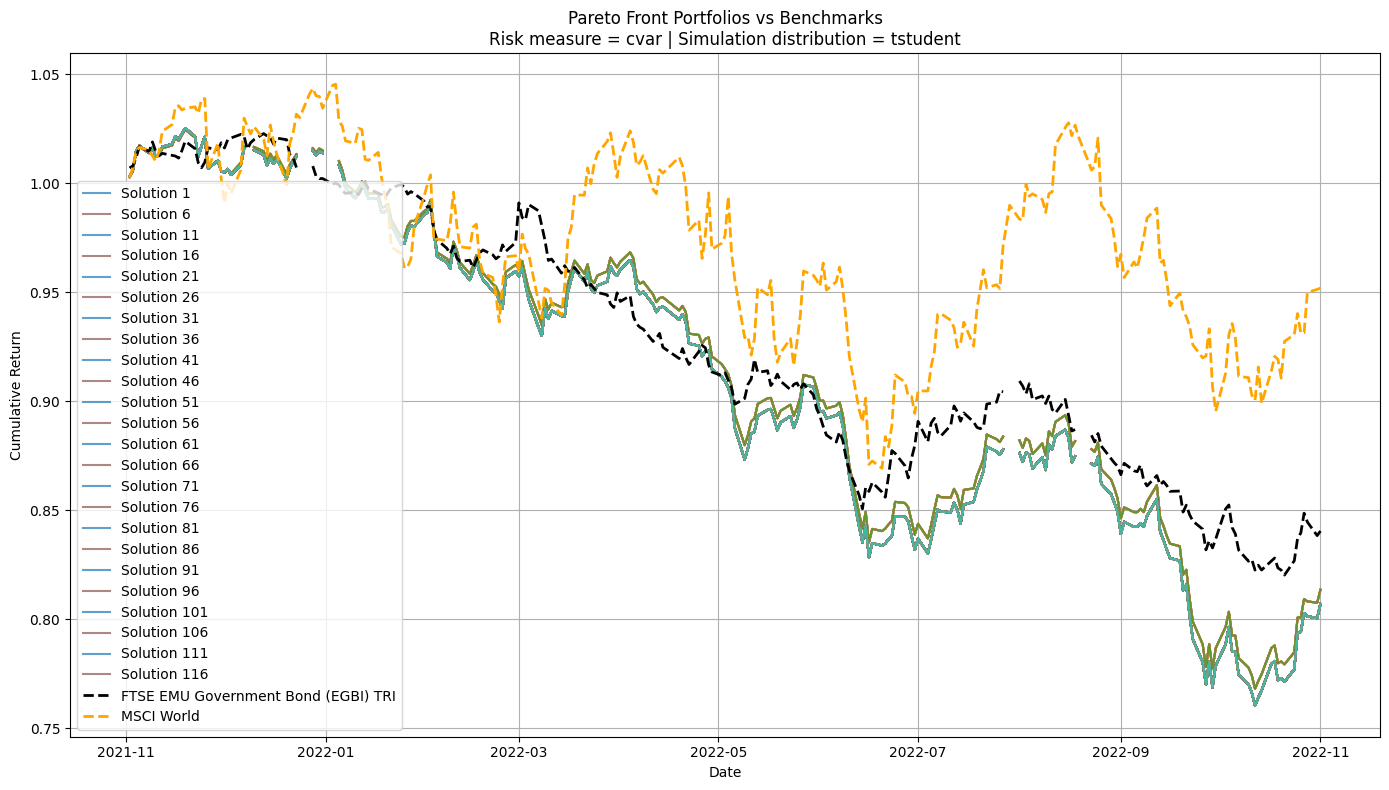

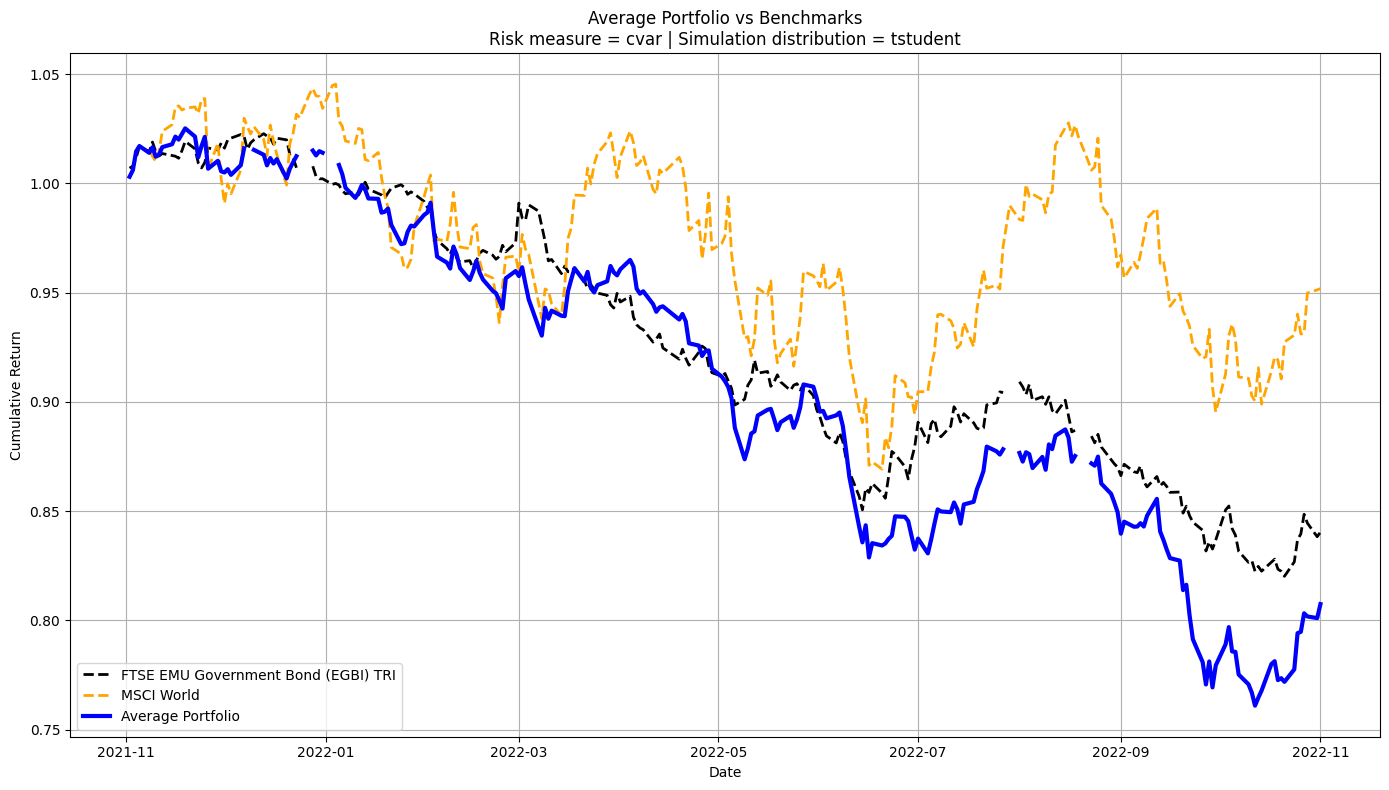


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



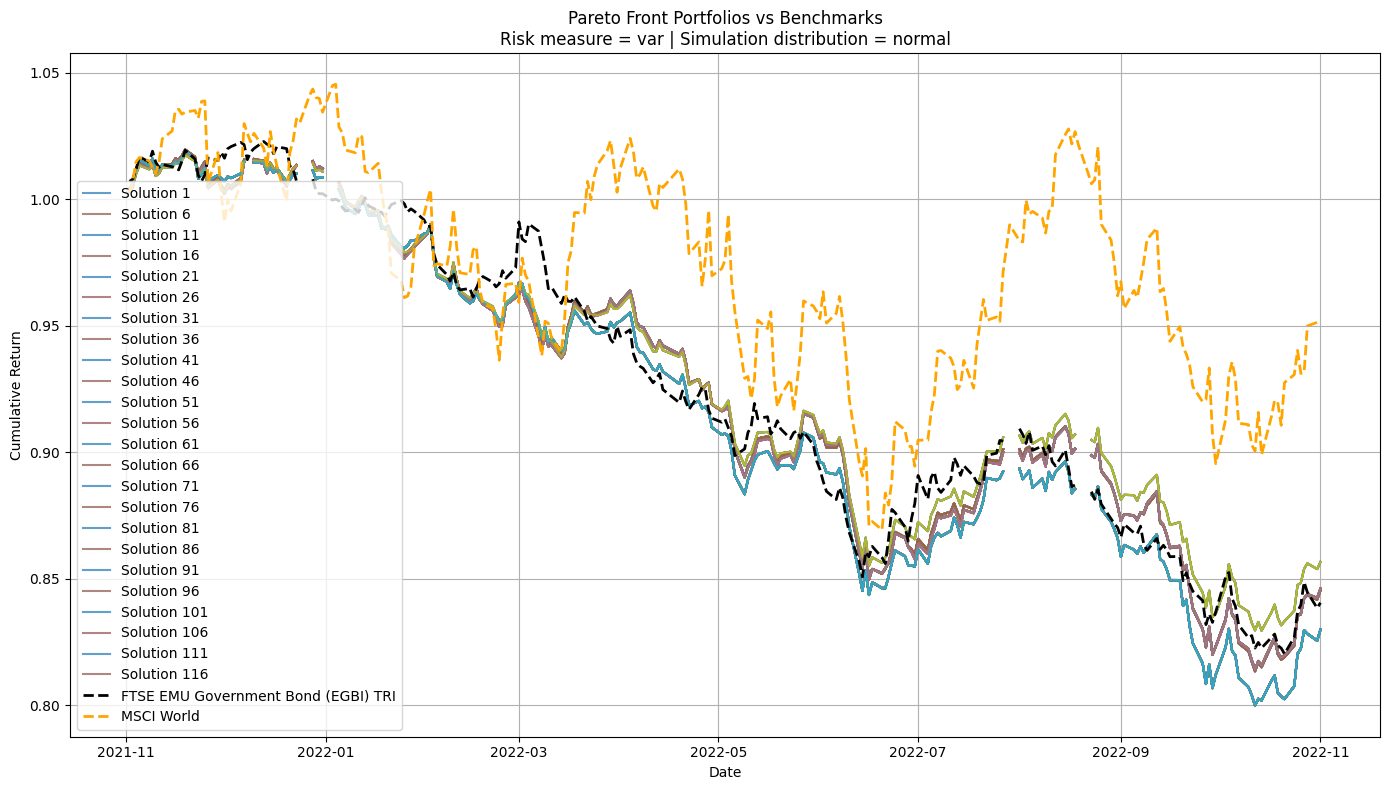

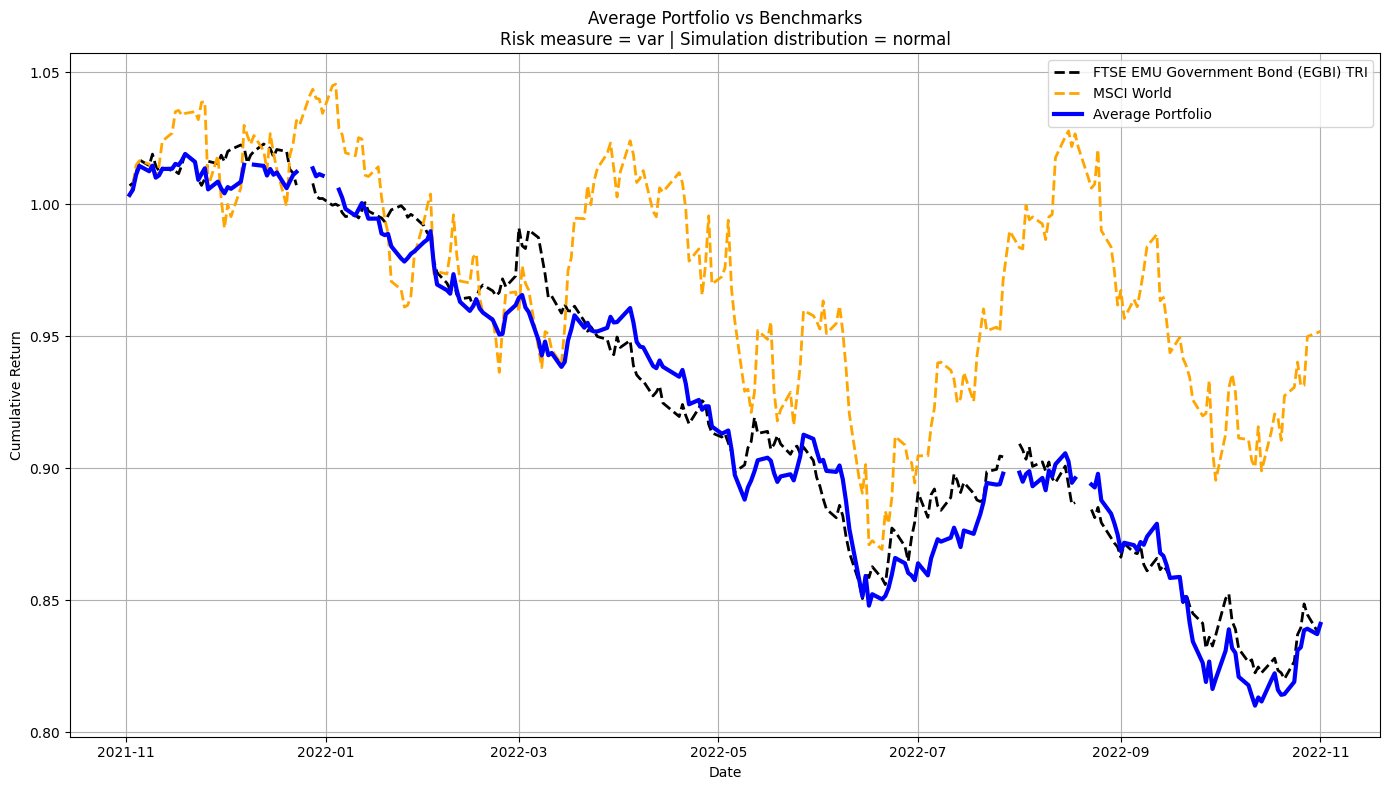


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



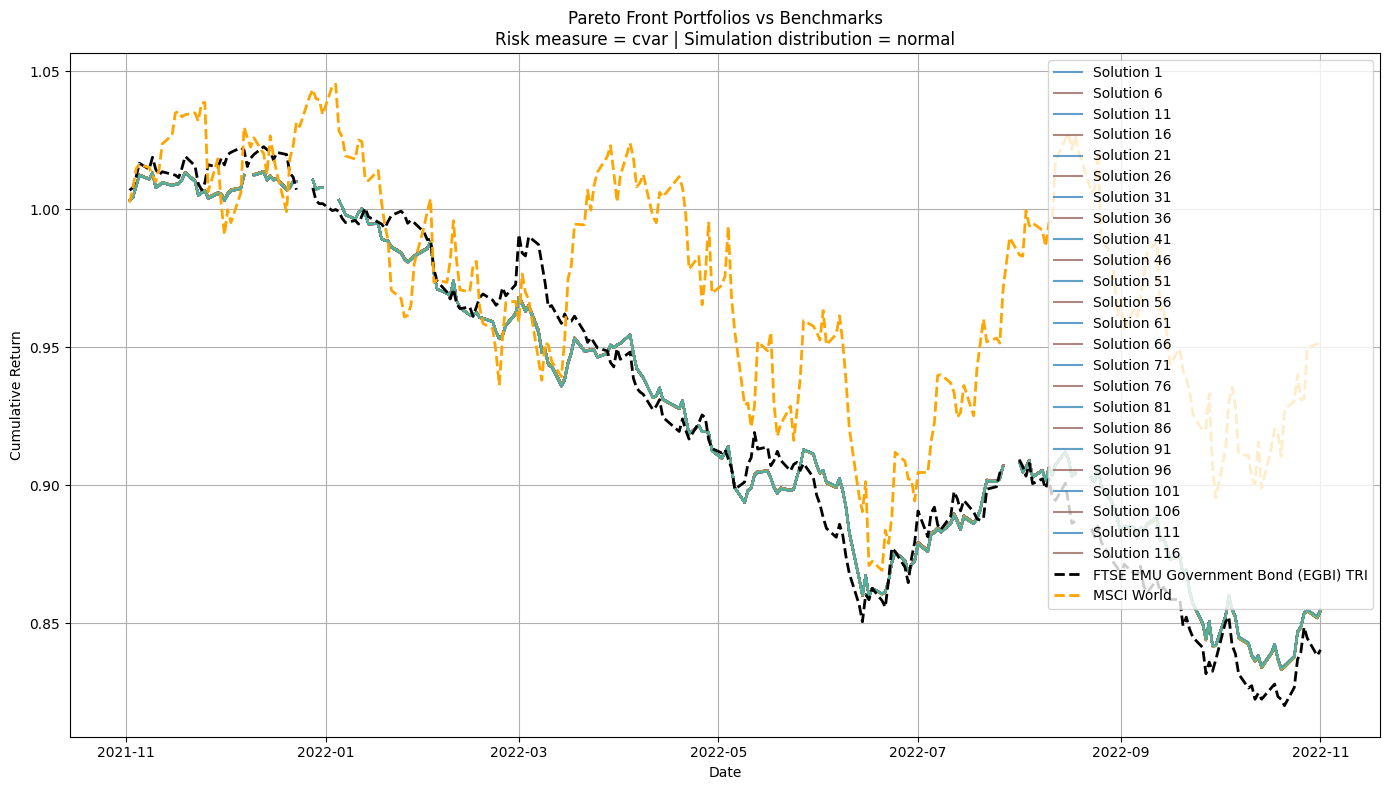

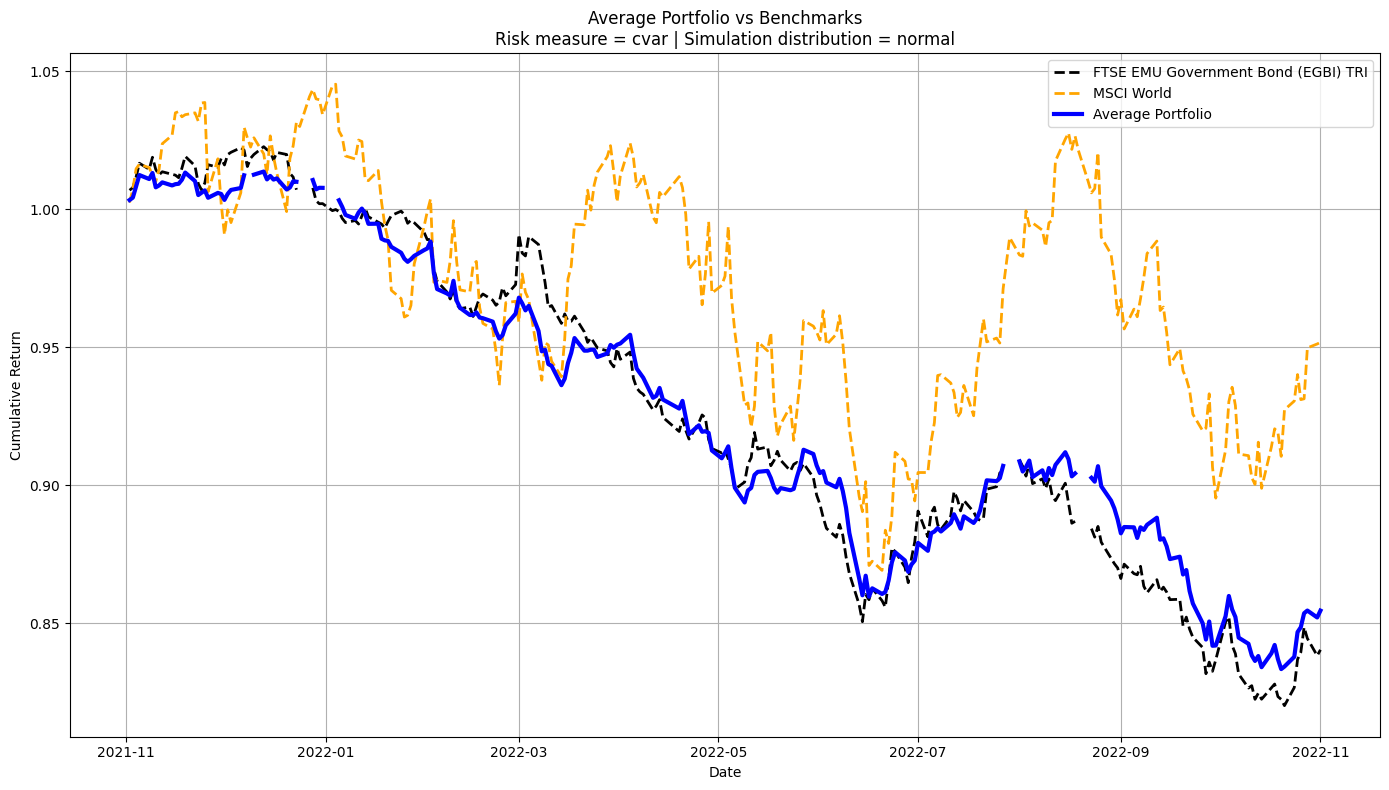


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



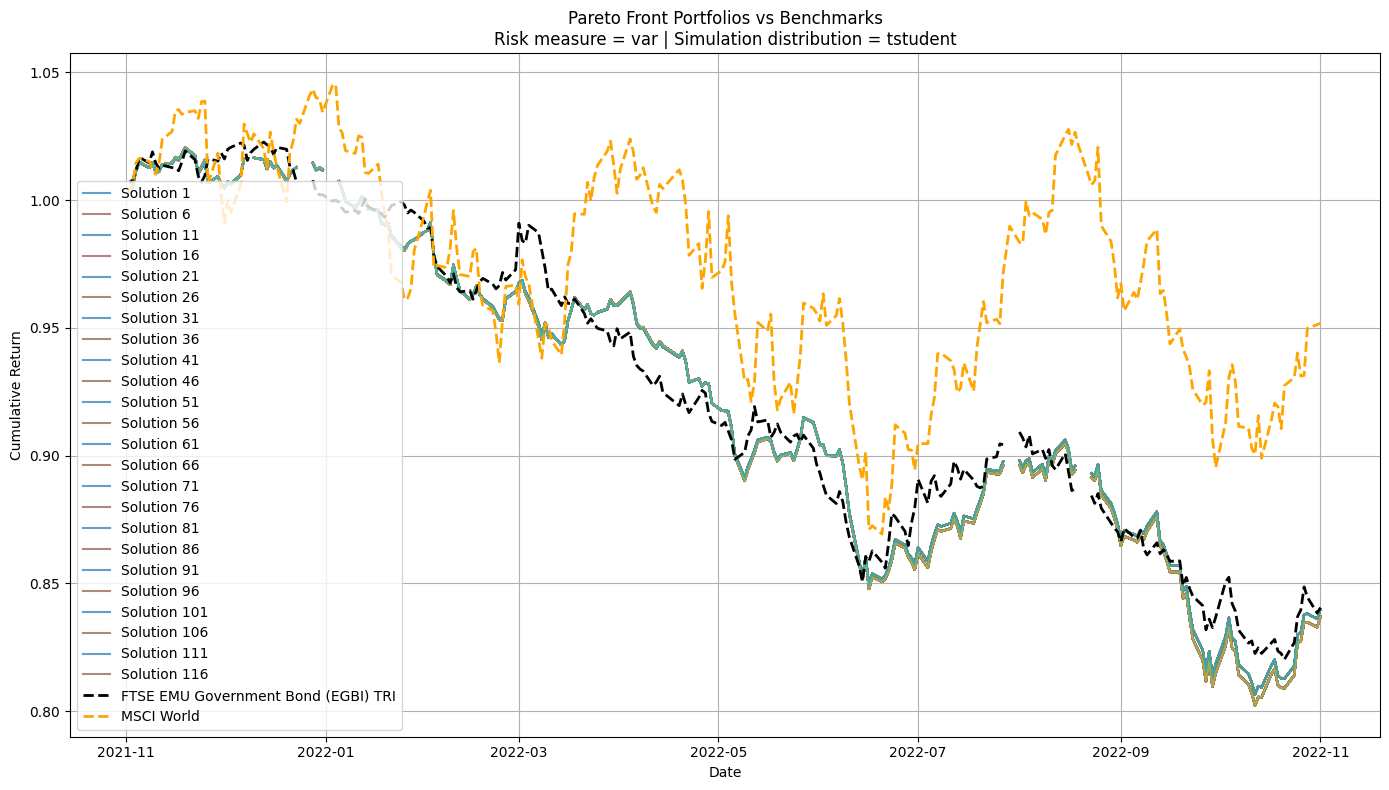

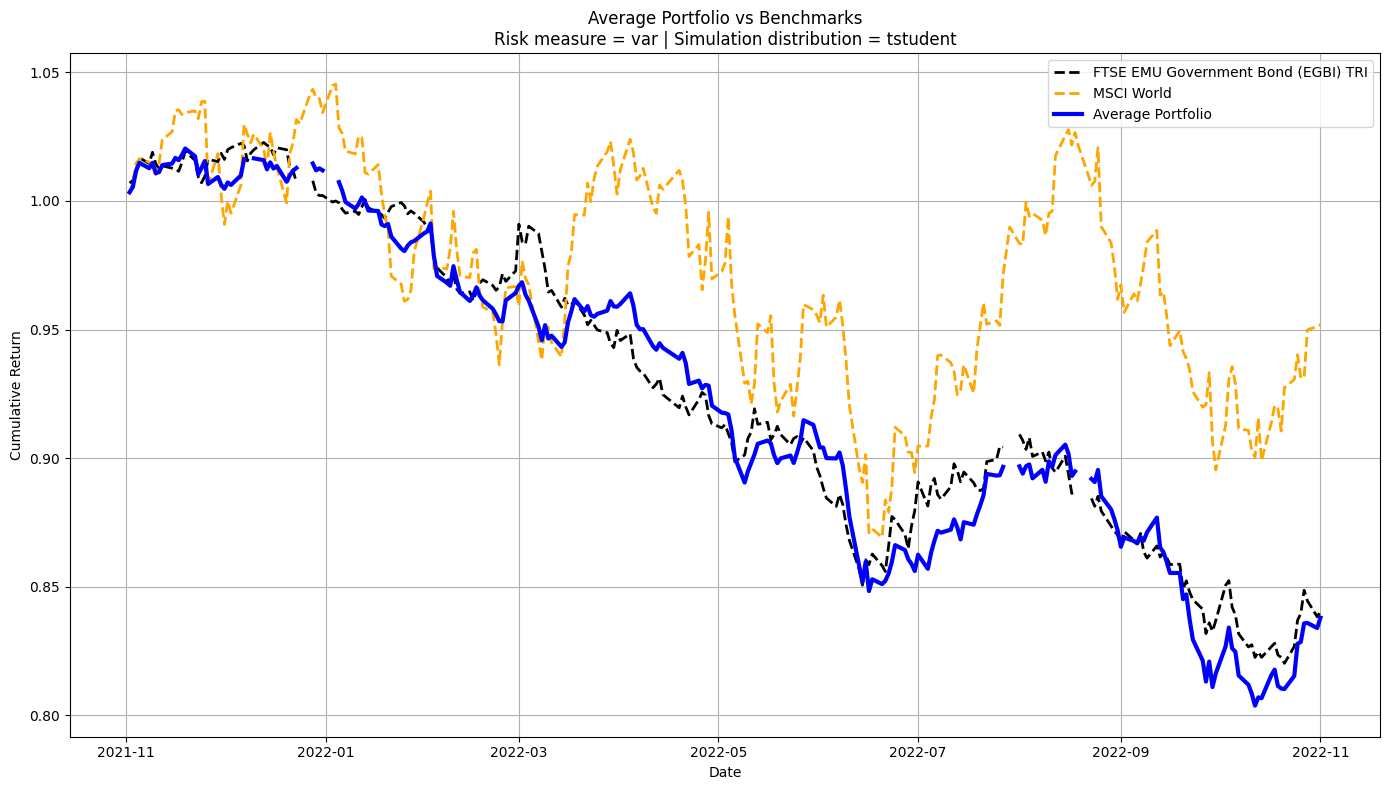


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



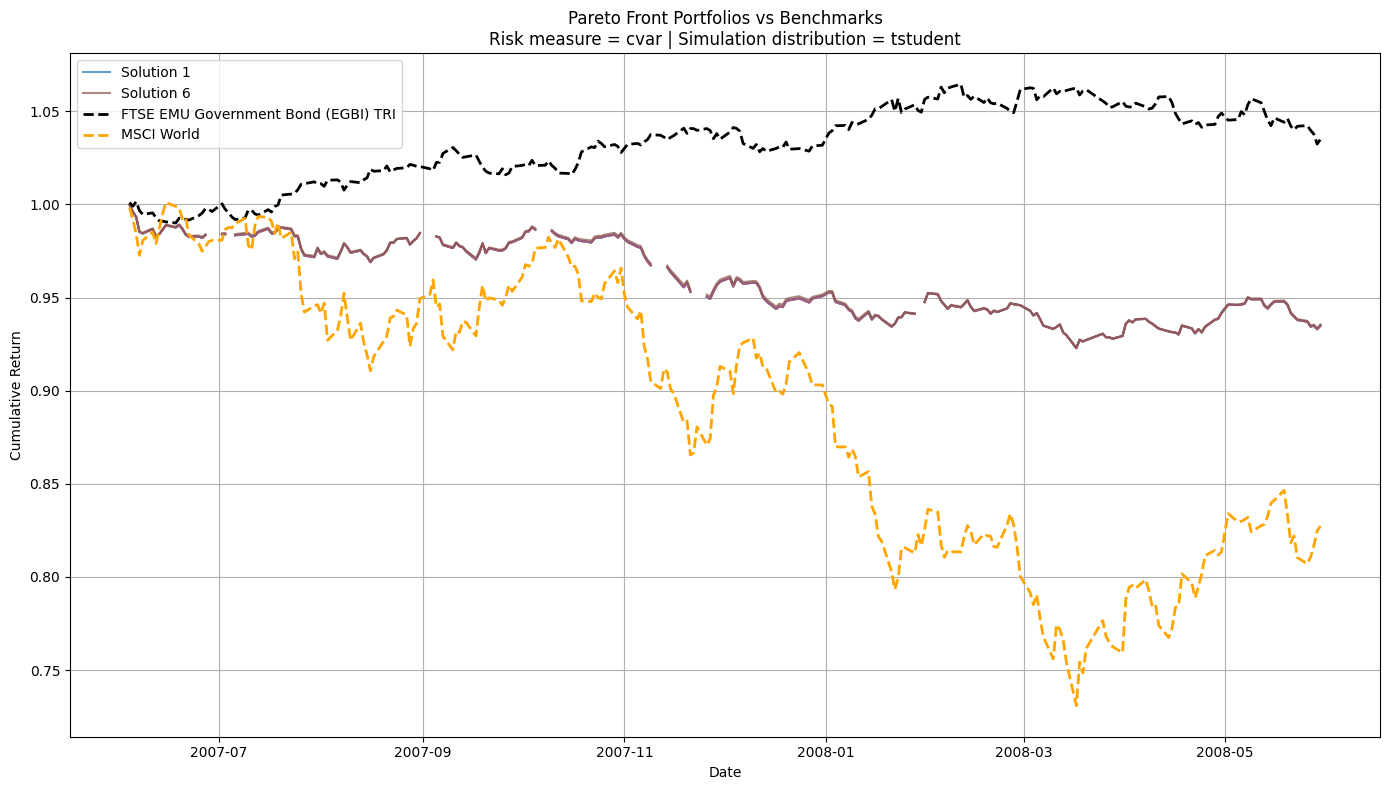

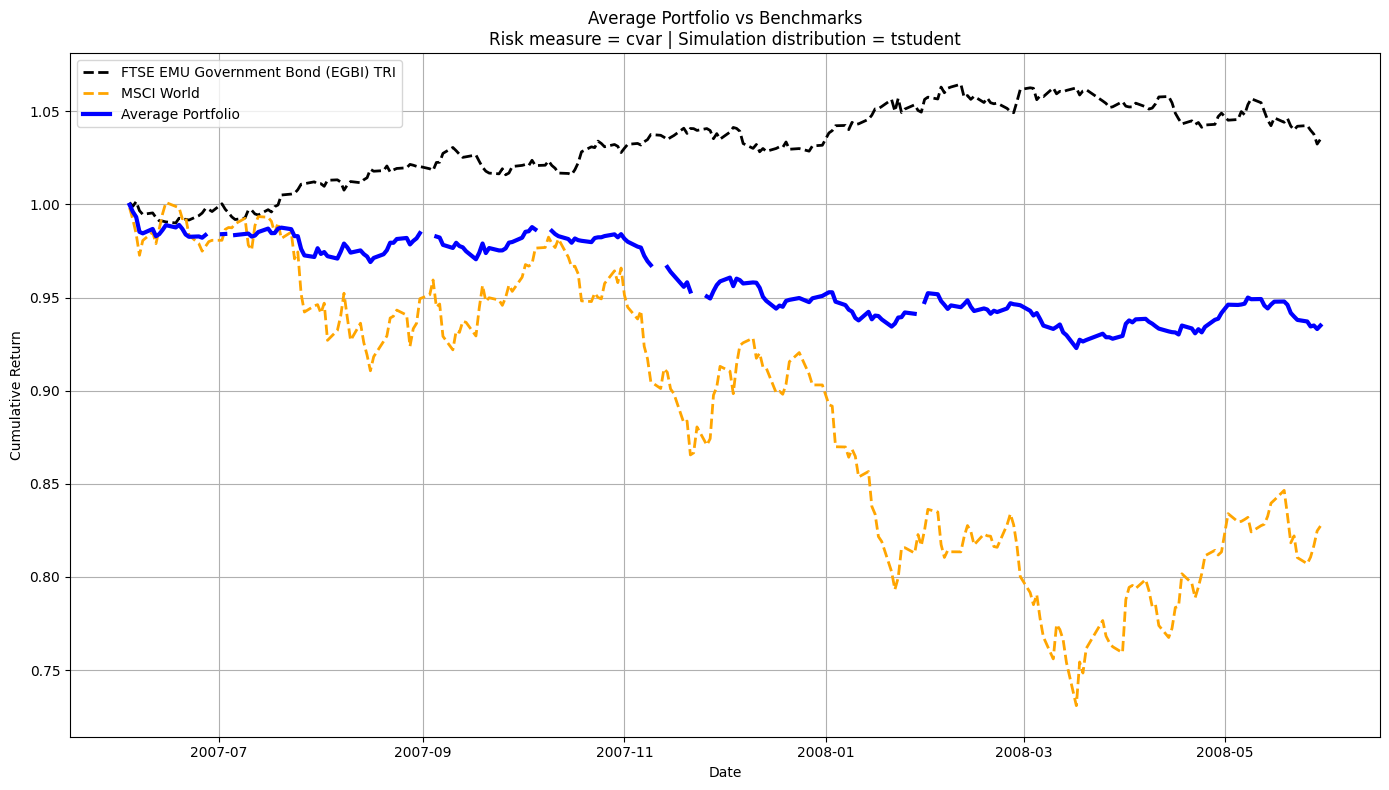


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



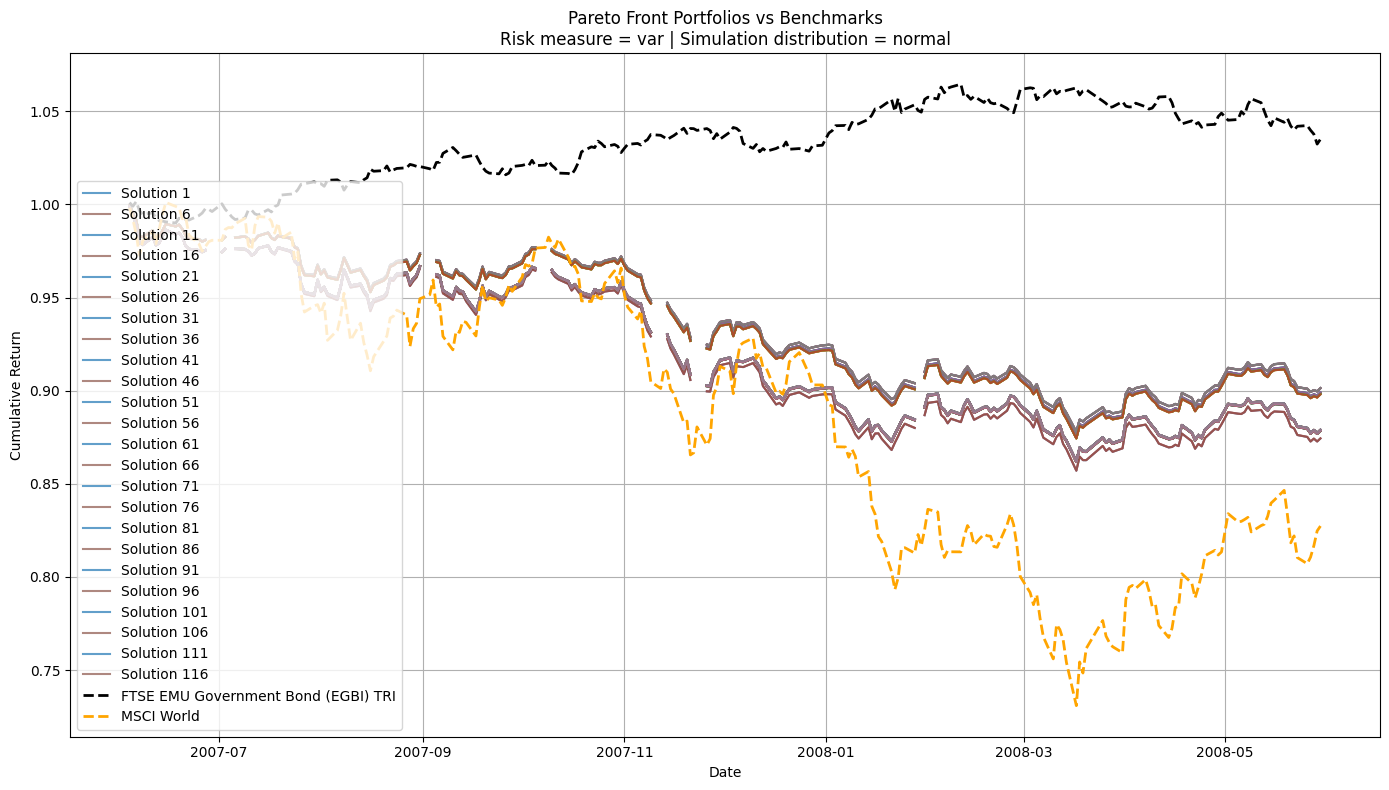

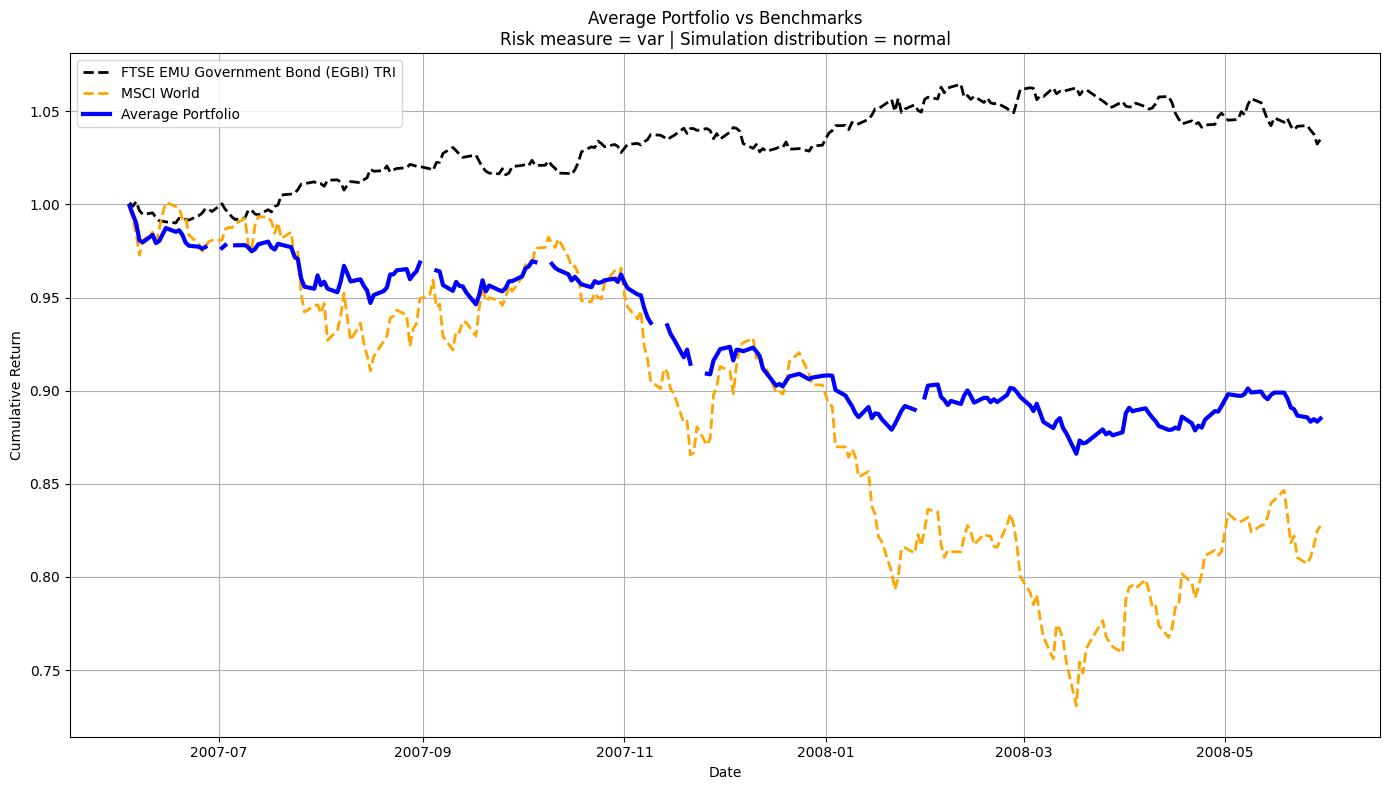


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [9]:
for front in all_runs:
    plot_results(front, show_average_only=False)
    plot_results(front, show_average_only=True)
    print('\n' + '-' * 250 + '\n')

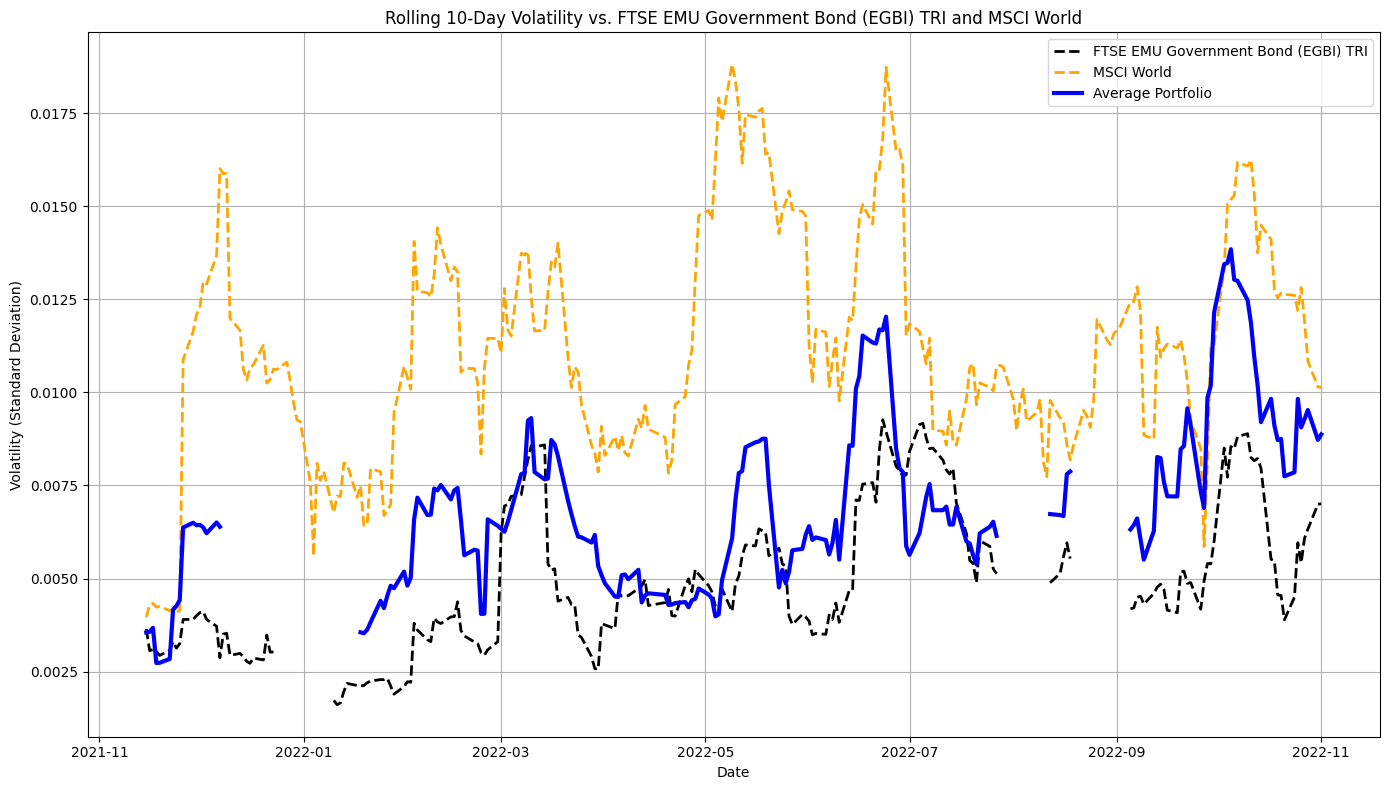


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



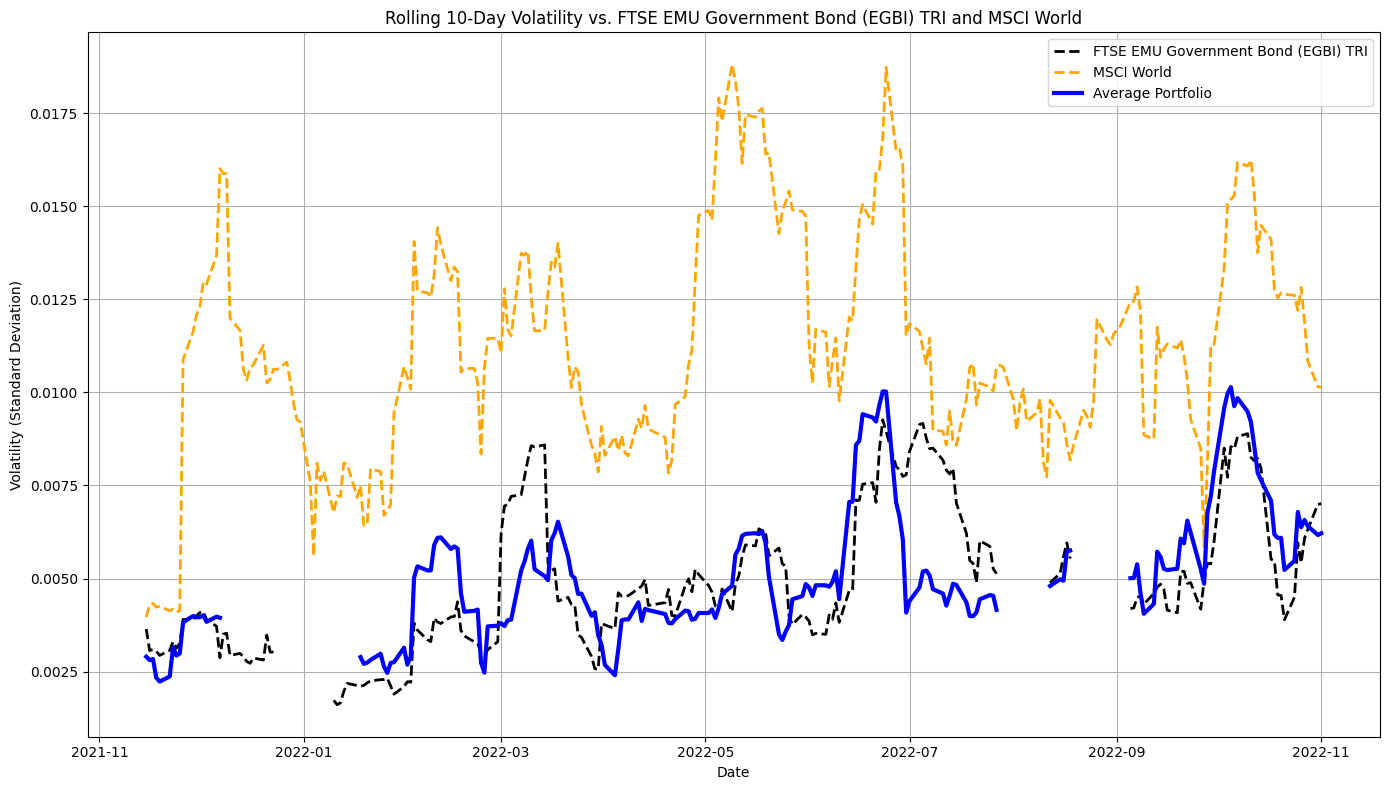


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



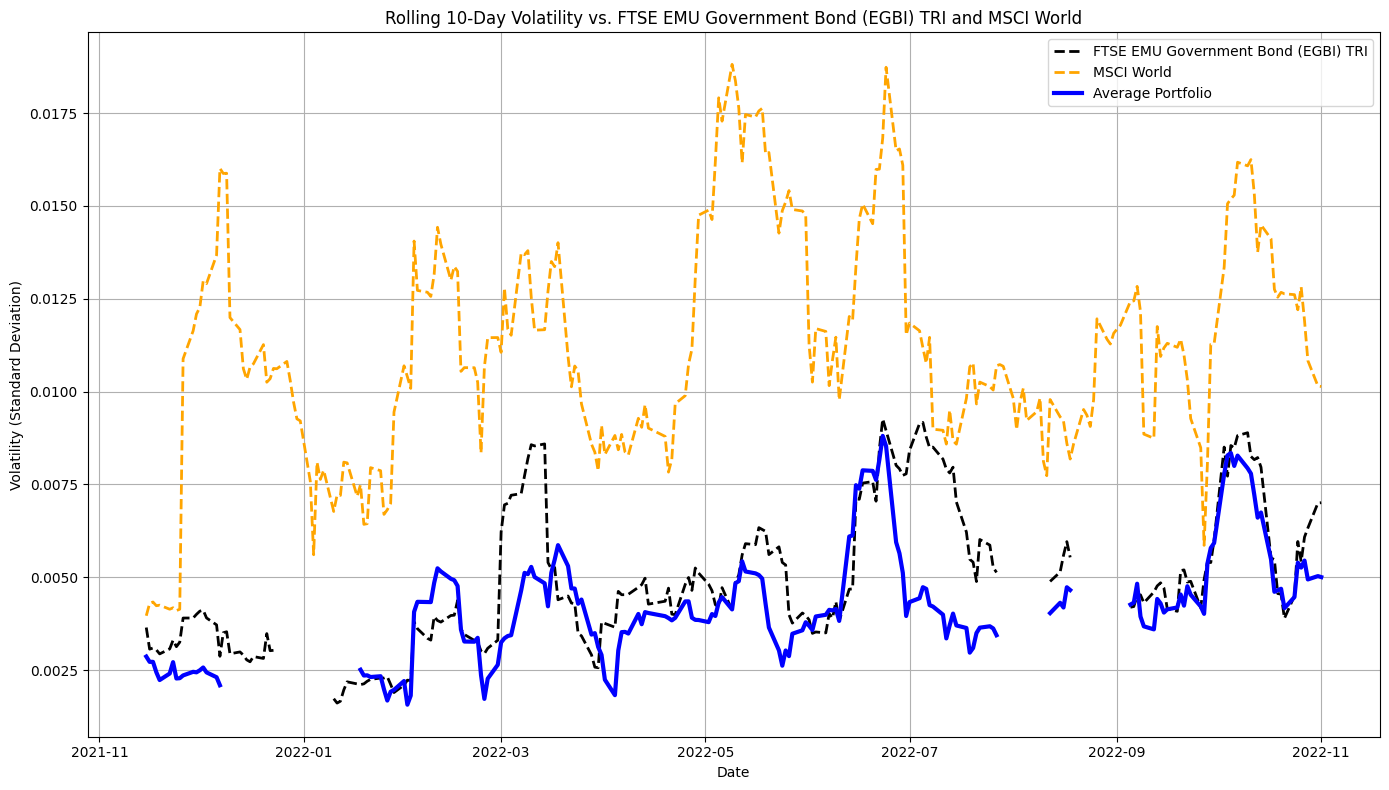


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



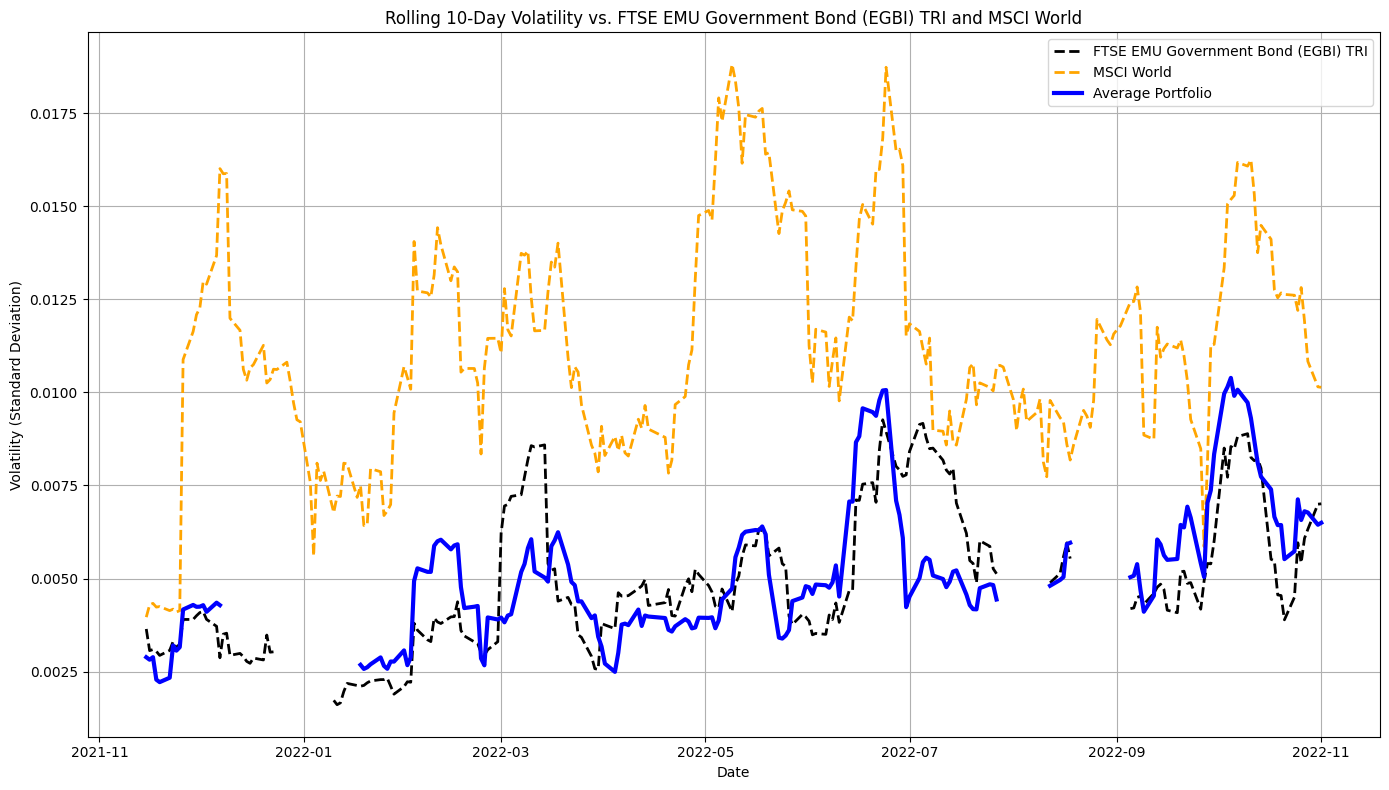


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



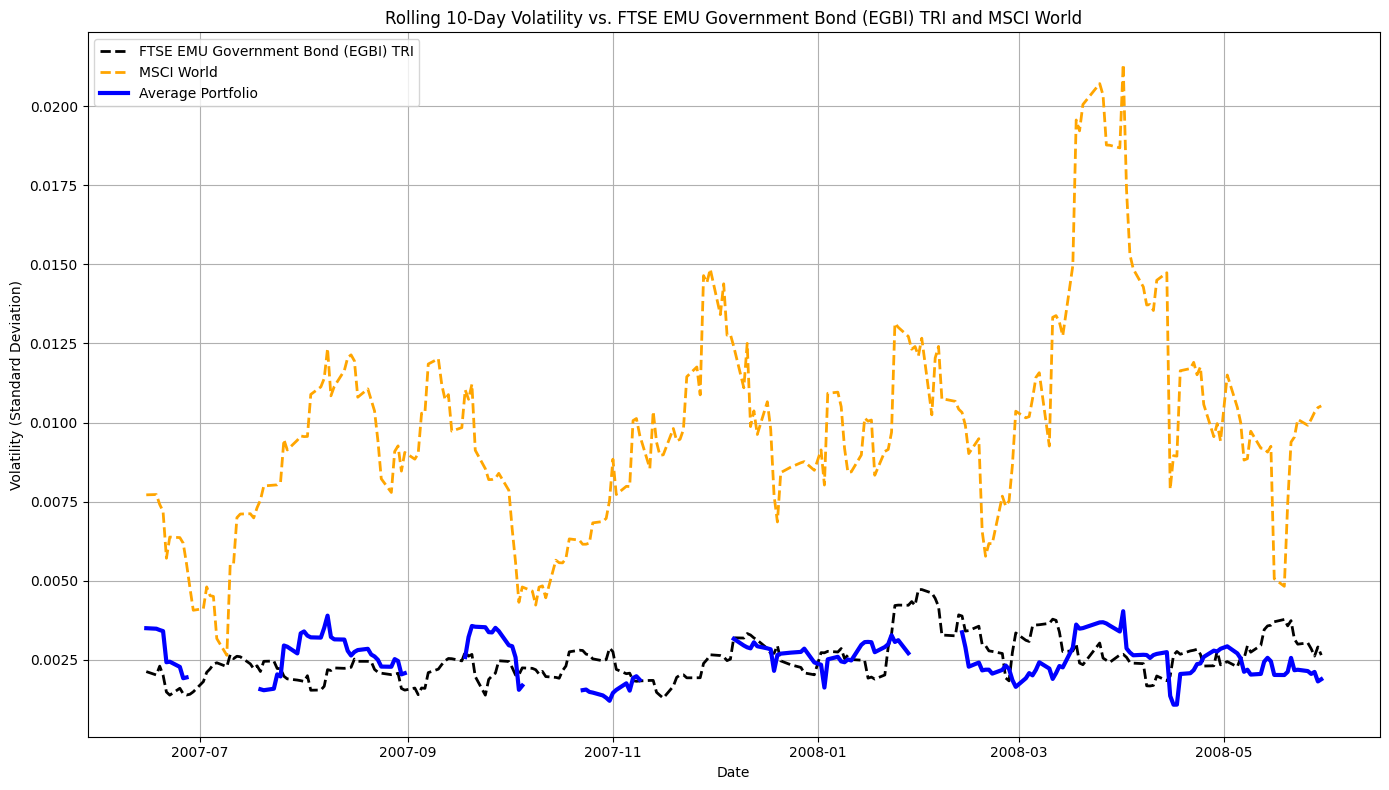


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



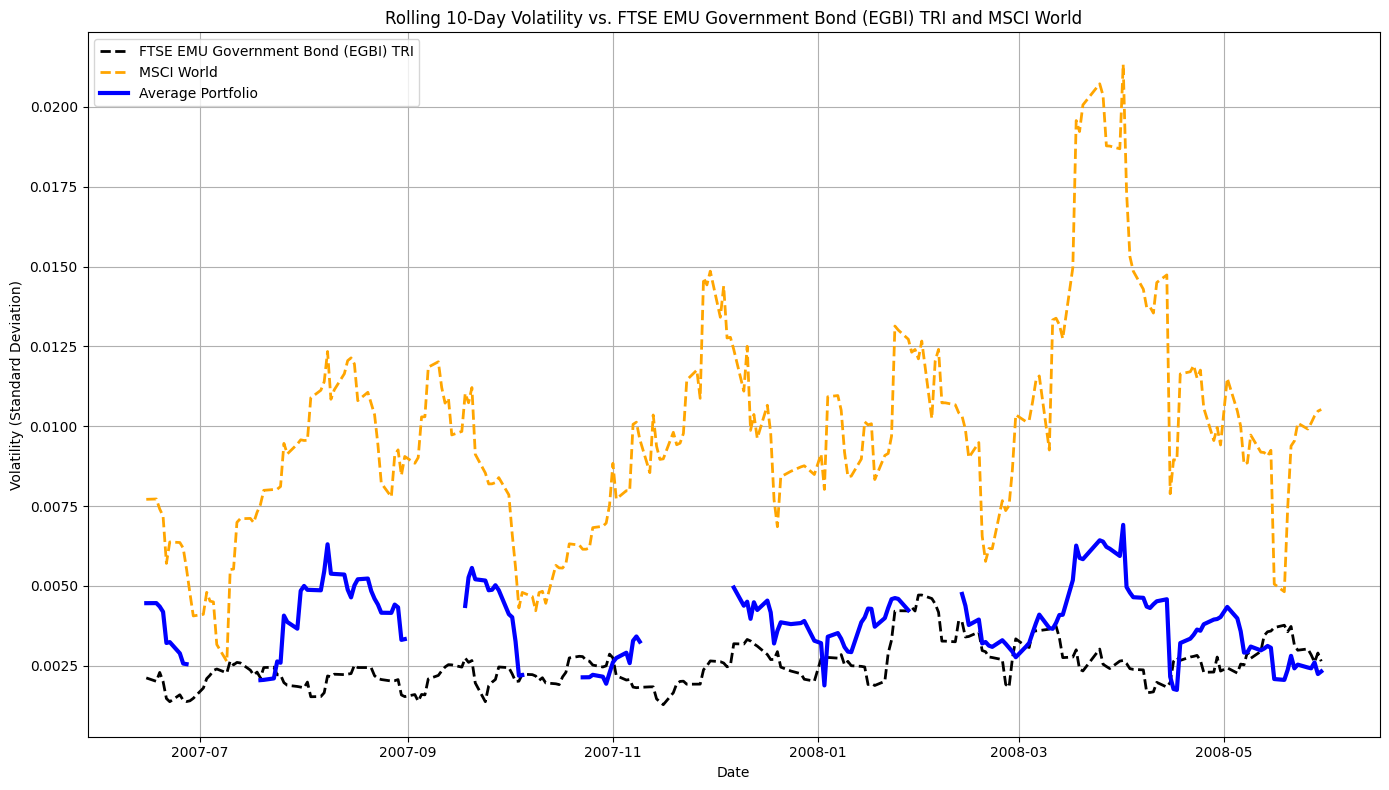


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [10]:
for front in all_runs:
    plot_volatility(front, show_average_only=True, window=10)
    print('\n' + '-' * 250 + '\n')
